# Libraries

## I/O

In [1]:
import os
from pprint import pprint
import pickle

from util_IO import (
    load_pickle_from_main_project_dir,
    load_attributes_df,
    load_timeseries_df
)

## Analysis

In [2]:
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE

# Settings

## Packages

In [3]:
# Set pandas to display a maximum of 300 columns
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 1000)

# Suppress the SettingWithCopyWarning
pd.options.mode.chained_assignment = None

## Parameters

### Load metadata from *1-DataAggregation.ipynb*

In [4]:
aggr_parameters_dict, camels_gb_use_case_dir = load_pickle_from_main_project_dir(
    'aggr_parameters_dict.pkl'
)

# # Print imported variable
pprint(aggr_parameters_dict)

{'attributes': {'aggregations': {'fundamental': {'chalk_streams_df': ['chalk_stream_flag'],
                                                 'climatic_attributes_df': [],
                                                 'humaninfluence_attributes_df': ['surfacewater_abs',
                                                                                  'groundwater_abs',
                                                                                  'discharges',
                                                                                  'num_reservoir',
                                                                                  'reservoir_cap'],
                                                 'hydrogeology_attributes_df': [],
                                                 'hydrologic_attributes_df': ['baseflow_index'],
                                                 'hydrometry_attributes_df': ['bankfull_flow'],
                                                 'landc

### Retrieve variables in use

In [5]:
camels_gb_data_attributes_aggr_dir = aggr_parameters_dict['camels_gb_data_attributes_aggr_dir']
attributes_index = aggr_parameters_dict["attributes"]["attributes_index"]
camels_gb_data_timeseries_aggr_dir = aggr_parameters_dict['camels_gb_data_timeseries_aggr_dir']
date_field = aggr_parameters_dict["timeseries"]["date_field"]
label_field = aggr_parameters_dict["timeseries"]['label_field']

# Attributes

## Retrieve aggregated file

In [6]:
# Attributes
attributes_df = load_attributes_df(
    camels_gb_data_attributes_aggr_dir,
    "fundamental_postEDA.csv",
    attributes_index
)

display(attributes_df.head(3))

,baseflow_index,sand_perc,silt_perc,clay_perc,organic_perc,gauge_name,gauge_lat,gauge_lon,gauge_elev,area,dpsbar,elev_mean,elev_min,elev_10,elev_50,elev_90,elev_max,dwood_perc,ewood_perc,grass_perc,shrub_perc,crop_perc,urban_perc,inwater_perc,bares_perc,surfacewater_abs,groundwater_abs,discharges,num_reservoir,reservoir_cap,chalk_stream_flag
gauge_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
53018,0.57,31.51,32.07,36.42,0.74,Avon at Bathford,51.40,-2.31,18.0,1569.35,48.9,109.0,20.3,53.3,104.0,172.1,304.6,6.38,0.65,50.46,0.04,35.01,6.91,0.19,0.48,0.034,0.051,0.066,0,0,False
33034,0.77,56.74,23.23,20.03,1.31,Little Ouse at Abbey Heath,52.43,0.72,7.2,707.75,16.3,42.0,8.1,25.3,41.7,60.0,94.6,8.49,7.07,13.07,0.33,65.76,5.14,0.30,0.00,0.004,0.046,0.020,0,0,True
55018,0.56,36.89,36.01,27.09,0.47,Frome at Yarkhill,52.08,-2.56,55.4,143.82,68.0,138.0,57.2,77.0,142.3,199.2,252.4,5.40,0.12,56.11,0.00,36.59,1.97,0.04,0.03,0.000,0.000,0.007,0,0,False


## Detach locations and names

In [7]:
# Define interested fields
locations_names_fields_list = [
    "gauge_name",
    "gauge_lat",
    "gauge_lon"
]

# Defining a separated data frame for this kind of information
attributes_location_names_df = attributes_df[locations_names_fields_list]

# Remove the field from the data frame which feeds the machine model
attributes_df.drop(
    columns=locations_names_fields_list,
    inplace=True
)

In [8]:
attributes_location_names_df.head()

,gauge_name,gauge_lat,gauge_lon
gauge_id,,,
53018,Avon at Bathford,51.40,-2.31
33034,Little Ouse at Abbey Heath,52.43,0.72
55018,Frome at Yarkhill,52.08,-2.56
49001,Camel at Denby,50.48,-4.80
27051,Crimple at Burn Bridge,53.96,-1.57


### Locations and names data frame elaboration

In [9]:
# Assert that each element in 'gauge_name' column contains exactly one 'at'
assert attributes_location_names_df['gauge_name'].apply(lambda x: x.count(' at ') == 1).all(), "Not all elements contain exactly one ' at '"

# Split 'gauge_name' column into two new columns 'tributary' and 'main'
location_split = (
    attributes_location_names_df['gauge_name']
        .str
        .split(' at ', expand=True)
        .rename(
            columns={0: "river", 1:"location"}
        )
)

# Concatenate
attributes_location_names_df = pd.concat(
    [attributes_location_names_df, location_split],
    axis=1
)


# Remove composed name
attributes_location_names_df.drop(
    columns='gauge_name',
    inplace=True
)

display(attributes_location_names_df.head(3))

,gauge_lat,gauge_lon,river,location
gauge_id,,,,
53018,51.40,-2.31,Avon,Bathford
33034,52.43,0.72,Little Ouse,Abbey Heath
55018,52.08,-2.56,Frome,Yarkhill


#### Count number of location per river

In [10]:
rivers_count_df = (
    attributes_location_names_df
        .groupby('river')
        .size()
        .reset_index(name='count')
        .sort_values(by='count', ascending=False)
)

# Change to `True` if you want to display counts on rivers
if False:   
    display(rivers_count_df)

# Timeseries

## Retrieve aggregated file

In [11]:
timeseries_df = load_timeseries_df(
    camels_gb_data_timeseries_aggr_dir,
    "timeseries_postEDA.csv",
    date_field
)

display(timeseries_df.head(3))

,catchmentID,date,precipitation,temperature,humidity,shortwave_rad,longwave_rad,windspeed,discharge_vol,date_group
0,101002,1997-03-01,0.26,8.31,6.11,73.68,320.09,6.23,0.319,00
1,101002,1997-03-02,0.10,9.55,5.64,89.11,315.49,6.51,0.314,00
2,101002,1997-03-03,24.15,5.84,4.98,51.62,320.09,2.75,0.397,00


## Add label transformation(s)

In [12]:
# log1p transformation
timeseries_df[f"log1p_{label_field}"] = np.log1p(timeseries_df[label_field])

## Define "beginning of the year"

In [13]:
# Set variables
year_start_month = 3
year_start_day = 21

## Add sin() and cos() functions to map the moment throughout the year

In [14]:
# ___________________________________
# Convert date column in Unix seconds
unix_sec_series = (
    timeseries_df[date_field]
        .apply(
            lambda x:
                int(
                    datetime.datetime.combine(x, datetime.datetime.min.time())
                        .timestamp()
                )
        )
)

# ______________________________________
# Find the oldest "beginning of the year"
first_beginning_year = (
    timeseries_df
        .loc[
            (pd.to_datetime(timeseries_df[date_field]).dt.month == year_start_month) & 
                (pd.to_datetime(timeseries_df[date_field]).dt.day == year_start_day)
        ]
    [date_field]
    .min()
)

first_beginning_year_unix_sec = pd.Timestamp(first_beginning_year).timestamp()

# ______________________________________________________________________
# Centred Unix second series to 0 for the `first_beginning_year_unix_sec`
unix_sec_centred_series = unix_sec_series - first_beginning_year_unix_sec


# Set the n° of "days" in a year
sec_in_a_year = 60*60*24*(365.2425)

# Add sin() and cos()
timeseries_df['sin_year'] = np.sin(unix_sec_centred_series * (2 * np.pi / sec_in_a_year))
timeseries_df['cos_year'] = np.cos(unix_sec_centred_series * (2 * np.pi / sec_in_a_year))

### Visual check

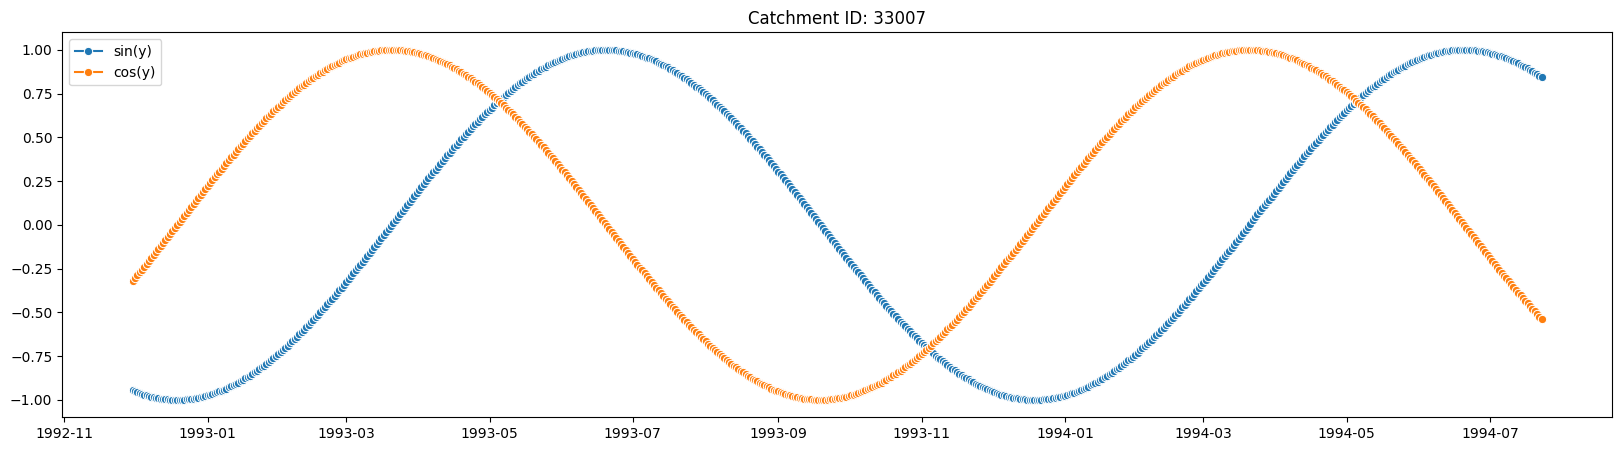

In [15]:
# Identify the catchmentID-group with the fewest rows but considerable amount of observations
combined_counts = timeseries_df.groupby(['catchmentID', f"{date_field}_group"]).size()

# Reducing to time series with at least (almost) 2 years
combined_counts = combined_counts[combined_counts > 600]

# Retrieve the shortest (for display matter)
min_index = combined_counts.idxmin()

# Filter the DataFrame
min_timeseries_df = (
    timeseries_df[
        (timeseries_df['catchmentID'] == min_index[0]) &
            (timeseries_df[f"{date_field}_group"] == min_index[1])
    ]
)

# Plot
plt.figure(figsize=(20, 5))
sns.lineplot(data=min_timeseries_df, x=date_field, y='sin_year', marker='o', label='sin(y)')
sns.lineplot(data=min_timeseries_df, x=date_field, y='cos_year', marker='o', label='cos(y)')
plt.title(f'Catchment ID: {min_index[0]}')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()

## Add time reference

Add time reference, starting with 1 for the oldest observation, and increase by 1 for each following day.

In [16]:
# Find the oldest date
oldest_date = pd.to_datetime(timeseries_df[date_field].min())
newest_date = pd.to_datetime(timeseries_df[date_field].max())

print(f"Oldest date within the dataset, regardless catchment ID:\t{oldest_date}")
print(f"Newest date within the dataset, regardless catchment ID:\t{newest_date}")

# Calculate the difference in days from the oldest date
timeseries_df['time_ref'] = (pd.to_datetime(timeseries_df[date_field]) - oldest_date).dt.days

Oldest date within the dataset, regardless catchment ID:	1970-10-01 00:00:00
Newest date within the dataset, regardless catchment ID:	2015-09-30 00:00:00


### Sample check

In [17]:
display(
    timeseries_df[[date_field, 'time_ref']]
        .sample(n=10)
        .sort_values(date_field)
)

,date,time_ref
2623863,1971-09-09,343
4873945,1975-01-03,1555
130196,1979-02-15,3059
4014229,1982-07-13,4303
498160,1986-04-30,5690
383277,1990-01-13,7044
936471,2004-02-27,12202
2228701,2004-05-29,12294
4204121,2008-09-28,13877
4981756,2014-12-23,16154


### Add a scaled `time_ref` (***deprecated***)

In [18]:
timeseries_df['time_ref_scaled'] = timeseries_df['time_ref'] / ((newest_date-oldest_date).days)

assert (timeseries_df['time_ref_scaled'].max()==1) and (timeseries_df['time_ref_scaled'].min()==0), "Something wrong during calculation of the dates and/or while scaling"

# Save

In [19]:
# _____________
# attributes_df

# Define path to save
path = os.path.join(
        camels_gb_data_attributes_aggr_dir,
        "fundamental_postFEa.csv"
)

# Save attributes
attributes_df.to_csv(path)


# Define path to save
path = os.path.join(
        camels_gb_data_attributes_aggr_dir,
        "fundamental_locations_postFEa.csv"
)

# Save attributes locations
attributes_location_names_df.to_csv(path)

# _____________
# timeseries_df

# Define path to save
path = os.path.join(
        camels_gb_data_timeseries_aggr_dir,
        "timeseries_postFEa.csv"
)

# Save
timeseries_df.to_csv(
    path,
    index=False
)

# Custom analysis with the `whole_set_df`

## Whole variables set data frame construction

In [20]:
whole_set_df = (
    timeseries_df
        .merge(
            attributes_df,
            left_on='catchmentID',
            right_index=True,
            how='left'
        )
)

assert whole_set_df.isna().sum().sum() == 0, "Some NaN in the sample, please check!"

whole_set_df.drop(
    columns=[
        'discharge_vol',
        'date_group',
        'log1p_discharge_vol',
        'time_ref_scaled',
        
    ],
    inplace=True
)

In [21]:
display(whole_set_df.head())

,catchmentID,date,precipitation,temperature,humidity,shortwave_rad,longwave_rad,windspeed,sin_year,cos_year,time_ref,baseflow_index,sand_perc,silt_perc,clay_perc,organic_perc,gauge_elev,area,dpsbar,elev_mean,elev_min,elev_10,elev_50,elev_90,elev_max,dwood_perc,ewood_perc,grass_perc,shrub_perc,crop_perc,urban_perc,inwater_perc,bares_perc,surfacewater_abs,groundwater_abs,discharges,num_reservoir,reservoir_cap,chalk_stream_flag
0,101002,1997-03-01,0.26,8.31,6.11,73.68,320.09,6.23,-0.326029,0.945360,9648,0.68,70.99,15.36,13.66,0.43,10.4,30.61,80.0,60.0,9.4,26.8,56.8,98.0,193.2,6.2,0.3,42.78,0.38,46.34,3.28,0.49,0.56,0.006,0.023,0.018,0,0,True
1,101002,1997-03-02,0.10,9.55,5.64,89.11,315.49,6.51,-0.309718,0.950828,9649,0.68,70.99,15.36,13.66,0.43,10.4,30.61,80.0,60.0,9.4,26.8,56.8,98.0,193.2,6.2,0.3,42.78,0.38,46.34,3.28,0.49,0.56,0.006,0.023,0.018,0,0,True
2,101002,1997-03-03,24.15,5.84,4.98,51.62,320.09,2.75,-0.293316,0.956015,9650,0.68,70.99,15.36,13.66,0.43,10.4,30.61,80.0,60.0,9.4,26.8,56.8,98.0,193.2,6.2,0.3,42.78,0.38,46.34,3.28,0.49,0.56,0.006,0.023,0.018,0,0,True
3,101002,1997-03-04,3.06,8.56,6.73,31.00,336.67,3.50,-0.276828,0.960920,9651,0.68,70.99,15.36,13.66,0.43,10.4,30.61,80.0,60.0,9.4,26.8,56.8,98.0,193.2,6.2,0.3,42.78,0.38,46.34,3.28,0.49,0.56,0.006,0.023,0.018,0,0,True
4,101002,1997-03-05,2.00,8.52,6.11,59.23,330.95,4.14,-0.260257,0.965539,9652,0.68,70.99,15.36,13.66,0.43,10.4,30.61,80.0,60.0,9.4,26.8,56.8,98.0,193.2,6.2,0.3,42.78,0.38,46.34,3.28,0.49,0.56,0.006,0.023,0.018,0,0,True


## Cluster analysis

### Define data set for clustering

In [22]:
cluster_set_df = (
    whole_set_df
        .drop(
            columns=[
                'catchmentID',
                'date',
                'precipitation',
                'temperature',
                'humidity',
                'shortwave_rad',
                'longwave_rad',
                'windspeed',
                'sin_year',
                'cos_year',
                'time_ref'
            ]
        )
        .drop_duplicates()
        .reset_index(drop=True)
)

hue_variables = cluster_set_df.columns.to_list()


display(cluster_set_df.head())

,baseflow_index,sand_perc,silt_perc,clay_perc,organic_perc,gauge_elev,area,dpsbar,elev_mean,elev_min,elev_10,elev_50,elev_90,elev_max,dwood_perc,ewood_perc,grass_perc,shrub_perc,crop_perc,urban_perc,inwater_perc,bares_perc,surfacewater_abs,groundwater_abs,discharges,num_reservoir,reservoir_cap,chalk_stream_flag
0,0.68,70.99,15.36,13.66,0.43,10.4,30.61,80.0,60.0,9.4,26.8,56.8,98.0,193.2,6.20,0.30,42.78,0.38,46.34,3.28,0.49,0.56,0.006,0.023,0.018,0,0,True
1,0.62,71.01,15.56,13.45,0.45,17.2,24.31,87.0,92.0,17.2,32.9,84.0,157.2,234.6,4.60,0.12,59.24,0.25,31.08,4.78,0.05,0.00,0.001,0.015,0.053,0,0,True
2,0.51,45.16,31.88,22.96,4.13,5.2,578.25,110.0,225.0,5.2,79.3,192.8,420.0,774.5,5.87,9.60,59.92,11.13,12.49,0.95,0.13,0.00,0.000,0.006,0.004,0,0,False
3,0.43,37.67,35.23,27.10,0.54,24.6,273.67,31.9,115.0,24.0,57.8,110.5,185.4,265.2,5.29,0.76,45.06,0.13,44.22,3.85,0.27,0.57,0.065,0.000,0.002,0,0,False
4,0.44,39.41,34.78,25.81,1.56,31.4,282.01,50.8,182.0,30.8,93.9,176.1,283.1,442.2,6.57,13.89,56.64,5.43,16.66,0.57,0.45,0.00,0.066,0.000,0.000,1,3279,False


### Clustering

In [25]:
# Set `n_components`
n_components = 2

# Initialize t-SNE
tsne = TSNE(
    n_components=2,
    learning_rate=200,
    perplexity=50,
    early_exaggeration=6.0,
    init='pca',
    max_iter=3000,
    random_state=82
)

# Retrieve data
X = (
    cluster_set_df
        .drop(
            columns=[
                'elev_mean',
                'elev_min',
                'elev_10',
                'elev_50',
                'elev_90',
                'elev_max'	
            ]
        )
        .values
)

# Fit and transform the data
X_embedded = tsne.fit_transform(X)

# Aggregate results to `whole_set_df`
for i in range(n_components):
    cluster_set_df[f"Component {i+1}"] = X_embedded[:, i]
    
display(cluster_set_df.head())

,baseflow_index,sand_perc,silt_perc,clay_perc,organic_perc,gauge_elev,area,dpsbar,elev_mean,elev_min,elev_10,elev_50,elev_90,elev_max,dwood_perc,ewood_perc,grass_perc,shrub_perc,crop_perc,urban_perc,inwater_perc,bares_perc,surfacewater_abs,groundwater_abs,discharges,num_reservoir,reservoir_cap,chalk_stream_flag,Component 1,Component 2
0,0.68,70.99,15.36,13.66,0.43,10.4,30.61,80.0,60.0,9.4,26.8,56.8,98.0,193.2,6.20,0.30,42.78,0.38,46.34,3.28,0.49,0.56,0.006,0.023,0.018,0,0,True,-13.842931,-4.782907
1,0.62,71.01,15.56,13.45,0.45,17.2,24.31,87.0,92.0,17.2,32.9,84.0,157.2,234.6,4.60,0.12,59.24,0.25,31.08,4.78,0.05,0.00,0.001,0.015,0.053,0,0,True,-13.313349,-5.294800
2,0.51,45.16,31.88,22.96,4.13,5.2,578.25,110.0,225.0,5.2,79.3,192.8,420.0,774.5,5.87,9.60,59.92,11.13,12.49,0.95,0.13,0.00,0.000,0.006,0.004,0,0,False,10.407739,3.709852
3,0.43,37.67,35.23,27.10,0.54,24.6,273.67,31.9,115.0,24.0,57.8,110.5,185.4,265.2,5.29,0.76,45.06,0.13,44.22,3.85,0.27,0.57,0.065,0.000,0.002,0,0,False,4.878654,2.785088
4,0.44,39.41,34.78,25.81,1.56,31.4,282.01,50.8,182.0,30.8,93.9,176.1,283.1,442.2,6.57,13.89,56.64,5.43,16.66,0.57,0.45,0.00,0.066,0.000,0.000,1,3279,False,9.679469,-8.106547


### Plot clustering with `hue`

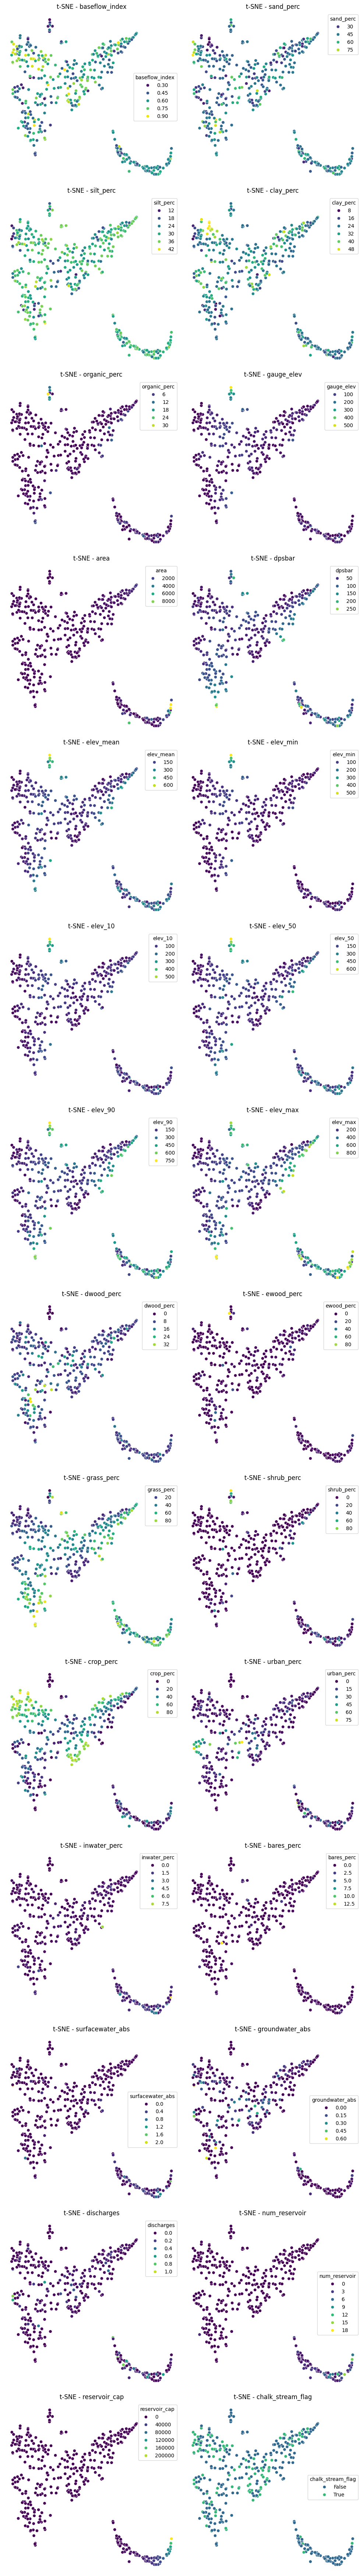

In [26]:
# Number of subplots
num_subplots = len(hue_variables)
num_columns = 2

# Calculate the number of rows needed
num_rows = (num_subplots + num_columns - 1) // num_columns

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(5 * num_columns, 5 * num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the variables and create a subplot for each
for i, var in enumerate(hue_variables):
    sns.scatterplot(
        data=cluster_set_df,
        x="Component 1",
        y="Component 2",
        hue=var,
        palette='viridis',
        ax=axes[i]
    )
    axes[i].set_title(f"t-SNE - {var}")
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

    # Remove the ticks
    axes[i].tick_params(left=False, bottom=False)
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])

    # Remove all spines
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['left'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()

# Save the figure as a PNG file
plt.savefig(
    os.path.join(
    camels_gb_use_case_dir,
    "resources",
    "charts",
    "03-FEa",
    'tsne_scatter_plots.png'
    )   
)

# Show the plot
plt.show()

## Custom split

### Custom split definition

In [ ]:
focus_catchments_list = [
    # Insert here your list of catchments to be analyzed
]


whole_set_df["On focus"] = (
    whole_set_df['catchmentID']
        .isin(focus_catchments_list)
)

### Custom split visualization

#### Custom split visualization function

In [28]:
def split_plot_distributions(
    df,
    boolean_column,
    max_columns_per_plot=5,
    save_path=None
):
    # Filter out string and date columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Calculate the number of plots needed
    num_plots = math.ceil(len(numeric_columns) / max_columns_per_plot)
    
    # Create subplots for each chunk of columns
    for i in range(num_plots):
        start_idx = i * max_columns_per_plot
        end_idx = (i + 1) * max_columns_per_plot
        columns_chunk = numeric_columns[start_idx:end_idx]
        
        # Create a figure with subplots
        fig, axes = plt.subplots(len(columns_chunk), 1, figsize=(10, len(columns_chunk) * 4))
        
        # Plot each column's KDE split by the boolean column
        for j, column in enumerate(columns_chunk):
            sns.kdeplot(
                data=df,
                x=column,
                hue=boolean_column,
                ax=axes[j],
                bw_adjust=1.5,
                fill=True,
                alpha=0.7,
                common_norm=False
            )
            axes[j].set_title(f'{column}')
            axes[j].set_xlabel('')
        
        # Adjust layout and show the plot
        plt.tight_layout()
        
        # Save the plot if save_path is provided
        if save_path:
            plt.savefig(f"{save_path}_part_{i + 1}.png", dpi=300)

        plt.show()

In [ ]:
# Define dir to save
path = os.path.join(
    camels_gb_use_case_dir,
    "resources",
    "charts",
    "03-FEa",
    "On_focus"
)

split_plot_distributions(
    whole_set_df,
    "On focus",
    max_columns_per_plot=7,
    save_path=path
)